In [38]:
SERVER = False

# Files and Directories
ROOT_DIR = ""
TRAIN_PATH = 'wav_train_subset'
STFT_FOLDER = 'stft'
CHECKPOINTS_FOLDER = "checkpoints"
PAIRS_FILE = 'pairs.csv'
VGG_VOX_WEIGHT_FILE = "vggvox_ident_net.mat"

# Data_Part
TOTAL_USERS = 100
CLIPS_PER_USER = 10
MIN_CLIP_DURATION = 3.

# ML_Part
TRAINING_USERS = 80
SIMILAR_PAIRS = 20
DISSIMILAR_PAIRS = SIMILAR_PAIRS

assert SIMILAR_PAIRS <= CLIPS_PER_USER * (CLIPS_PER_USER - 1)
# print("len of pairs.csv should be", (SIMILAR_PAIRS + DISSIMILAR_PAIRS) * TOTAL_USERS)

from tqdm import tqdm
import os
import sys
import time
import itertools
from collections import Counter
from IPython.core.display import HTML
import numpy as np
import pandas as pd
from scipy.io import loadmat
import scipy
import sklearn
import librosa
import librosa.display
import wave
import contextlib
import matplotlib.pyplot as plt
# import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable

from network import *


assert os.path.exists(STFT_FOLDER)
assert os.path.exists(CHECKPOINTS_FOLDER)

def get_rel_path(path, server=SERVER, root_dir=ROOT_DIR):
    if server:
        return os.path.join(root_dir, path)
    else:
        return path


def wavPlayer(filepath):
    src = """
    <head>
    <meta http-equiv="Content-Type" content="text/html; charset=utf-8">
    <title>Simple Test</title>
    </head>

    <body>
    <audio controls="controls" style="width:600px" >
      <source src="%s" type="audio/wav" />
      Your browser does not support the audio element.
    </audio>
    </body>
    """%(filepath)
    display(HTML(src))

In [39]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [40]:
weights = {}

# loading pretrained vog_vgg learned weights
vox_weights = loadmat(get_rel_path(VGG_VOX_WEIGHT_FILE), 
                      struct_as_record=False, squeeze_me=True)

for l in vox_weights['net'].layers[:-1]:
    if len(l.weights) > 0:
        weights[l.name] = l.weights
#         print(l.name, [i.shape for i in l.weights])
        
for i in weights:
    weights[i][0] = weights[i][0].T 

weights['conv1'][0] = np.expand_dims(weights['conv1'][0], axis=1)
weights['fc6'][0] = np.expand_dims(weights['fc6'][0], axis=3)
weights['fc7'][0] = np.expand_dims(weights['fc7'][0], axis=-1)
weights['fc7'][0] = np.expand_dims(weights['fc7'][0], axis=-1)

print(weights.keys())   
for key in weights:
    print(key, [i.shape for i in weights[key]])

dict_keys(['conv1', 'conv2', 'conv3', 'conv4', 'conv5', 'fc6', 'fc7', 'fc8'])
conv1 [(96, 1, 7, 7), (96,)]
conv2 [(256, 96, 5, 5), (256,)]
conv3 [(384, 256, 3, 3), (384,)]
conv4 [(256, 384, 3, 3), (256,)]
conv5 [(256, 256, 3, 3), (256,)]
fc6 [(4096, 256, 9, 1), (4096,)]
fc7 [(1024, 4096, 1, 1), (1024,)]
fc8 [(1300, 1024), (1300,)]


In [41]:
# parameters
conv_kernel1, n_f1, s1, p1 = 7, 96, 2, 1
pool_kernel1, pool_s1 = 3, 2

conv_kernel2, n_f2, s2, p2 = 5, 256, 2, 1
pool_kernel2, pool_s2 = 3, 2

conv_kernel3, n_f3, s3, p3 = 3, 384, 1, 1

conv_kernel4, n_f4, s4, p4 = 3, 256, 1, 1

conv_kernel5, n_f5, s5, p5 = 3, 256, 1, 1
pool_kernel5_x, pool_kernel5_y, pool_s5_x, pool_s5_y = 5, 3, 3, 2

conv_kernel6_x, conv_kernel6_y, n_f6, s6 = 9, 1, 4096, 1

conv_kernel7, n_f7, s7 = 1, 1024, 1

conv_kernel8, n_f8, s8 = 1, 1024, 1

In [42]:
class VggVox(nn.Module):
    '''
    Class for CNN architecture (VGGvox)
    '''
    def __init__(self, use_weights=True):
        super(VggVox, self).__init__()

        self.conv1 = nn.Sequential(nn.Conv2d(in_channels=1, 
                                             out_channels=n_f1, 
                                             kernel_size=conv_kernel1,
                                             stride=s1,
                                             padding=p1),
                                    nn.BatchNorm2d(num_features=n_f1),
                                    nn.ReLU(),
                                    nn.MaxPool2d(kernel_size=pool_kernel1,
                                                 stride=pool_s1))           
            
        self.conv2 = nn.Sequential(nn.Conv2d(in_channels=n_f1,
                                         out_channels=n_f2,
                                         kernel_size=conv_kernel2,
                                         stride=s2,
                                         padding=p2),
                                nn.BatchNorm2d(num_features=n_f2),
                                nn.ReLU(),
                                nn.MaxPool2d(kernel_size=pool_kernel2,
                                             stride=pool_s2))


        self.conv3 = nn.Sequential(nn.Conv2d(in_channels=n_f2,
                                             out_channels=n_f3,
                                             kernel_size=conv_kernel3,
                                             stride=s3,
                                             padding=p3),
                                    nn.BatchNorm2d(num_features=n_f3),
                                    nn.ReLU())

        self.conv4 = nn.Sequential(nn.Conv2d(in_channels=n_f3,
                                             out_channels=n_f4,
                                             kernel_size=conv_kernel4,
                                             stride=s4,
                                             padding=p4),
                                   nn.BatchNorm2d(num_features=n_f4),
                                   nn.ReLU())

        self.conv5 = nn.Sequential(nn.Conv2d(in_channels=n_f4,
                                             out_channels=n_f5,
                                             kernel_size=conv_kernel5,
                                             stride=s5,
                                             padding=p5),
                                   nn.BatchNorm2d(num_features=n_f5),
                                   nn.ReLU(),
                                   nn.MaxPool2d(kernel_size=(pool_kernel5_x, pool_kernel5_y),
                                                stride=(pool_s5_x, pool_s5_y)))

        self.fc6 = nn.Sequential(nn.Conv2d(in_channels=n_f5,
                                             out_channels=n_f6,
                                             kernel_size=(conv_kernel6_x, conv_kernel6_y),
                                             stride=s6),
                                 nn.BatchNorm2d(num_features=n_f6), 
                                 nn.ReLU())

        self.global_pool = nn.AvgPool2d

        self.fc7 = nn.Sequential(nn.Conv2d(in_channels=n_f6,
                                           out_channels=n_f7,
                                           kernel_size=conv_kernel7,
                                           stride=s7),
                                 nn.ReLU())

        self.fc8 = nn.Sequential(nn.Conv2d(in_channels=n_f7,
                                           out_channels=n_f8,
                                           kernel_size=conv_kernel8,
                                           stride=s8))
   
        if use_weights:
            self.conv1[0].weight = torch.nn.Parameter(torch.from_numpy(weights['conv1'][0]))
            self.conv1[1].weight = torch.nn.Parameter(torch.from_numpy(weights['conv1'][1]))
            
            self.conv2[0].weight = torch.nn.Parameter(torch.from_numpy(weights['conv2'][0]))
            self.conv2[1].weight = torch.nn.Parameter(torch.from_numpy(weights['conv2'][1]))
            
            self.conv3[0].weight = torch.nn.Parameter(torch.from_numpy(weights['conv3'][0]))
            self.conv3[1].weight = torch.nn.Parameter(torch.from_numpy(weights['conv3'][1]))
            
            self.conv4[0].weight = torch.nn.Parameter(torch.from_numpy(weights['conv4'][0]))
            self.conv4[1].weight = torch.nn.Parameter(torch.from_numpy(weights['conv4'][1]))
            
            self.conv5[0].weight = torch.nn.Parameter(torch.from_numpy(weights['conv5'][0]))
            self.conv5[1].weight = torch.nn.Parameter(torch.from_numpy(weights['conv5'][1]))            
            
            self.fc6[0].weight = torch.nn.Parameter(torch.from_numpy(weights['fc6'][0]))
            self.fc6[1].weight = torch.nn.Parameter(torch.from_numpy(weights['fc6'][1]))
            
            self.fc7[0].weight = torch.nn.Parameter(torch.from_numpy(weights['fc7'][0]))
   
    def forward_single(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.fc6(x)
        x = self.global_pool(kernel_size=x.size()[2:])(x)
        x = self.fc7(x)
        out = self.fc8(x)      
        out = out.view(-1, out.shape[1])
        return out
  
    def forward(self, input1, input2):
        output1 = self.forward_single(input1)
        output2 = self.forward_single(input2)
        return output1, output2

In [43]:
class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))
        return loss_contrastive

In [44]:
class VoxCelebDataset(Dataset):
    def __init__(self, pairs_fname=PAIRS_FILE, n_users=TRAINING_USERS, clips_per_user=CLIPS_PER_USER):
        pairs_file = pd.read_csv(get_rel_path(pairs_fname))
        self.all_user_ids = sorted(pairs_file.user1.unique())
        self.training_users = self.all_user_ids[: n_users]
        
        user1_subset = pairs_file[pairs_file.user1.isin(self.training_users)]
        user2_subset = user1_subset[user1_subset.user2.isin(self.training_users)]
        
        def balance_data(df):
            pairs_df = []
            for user in df.user1.unique():
                user_df = df[df.user1 == user]
                similar = user_df[user_df['label'] == 0].sample(n=SIMILAR_PAIRS)
                dissimilar = user_df[user_df['label'] == 1].sample(n=DISSIMILAR_PAIRS)
                pairs_df.append(pd.concat([similar, dissimilar]))

            pairs_df = pd.concat(pairs_df)
            return pairs_df
                
        pairs_df = balance_data(user2_subset)
        
        assert len(pairs_df[pairs_df.user1.isin(self.training_users)]) == len(pairs_df)
        assert len(pairs_df[pairs_df.user2.isin(self.training_users)]) == len(pairs_df)
        
        self.spec = pairs_df[['path1', 'path2', 'label']].values

    def __len__(self):
        return len(self.spec)

    def __getitem__(self, idx):
        spec1_path = get_rel_path(self.spec[idx][0])
        spec2_path = get_rel_path(self.spec[idx][1])
        label = int(self.spec[idx][2])
        
        spec1 = np.load(spec1_path)
        spec2 = np.load(spec2_path)
        
        spec1 = np.expand_dims(spec1, axis=0)
        spec2 = np.expand_dims(spec2, axis=0)
        
        assert spec1.ndim == 3, spec2.ndim == 3
        
        sample = {'spec1': spec1, 'spec2': spec2, 'label': label}

        return sample

In [45]:
def save_checkpoint(state, loss):
    """Save checkpoint if a new best is achieved"""
    fname = "checkpoint_" + time.strftime("%Y%m%d-%H%M%S") + "_" + str(loss.item()) + ".pth.tar"
    torch.save(state, get_rel_path(os.path.join(CHECKPOINTS_FOLDER, fname)))  # save checkpoint
    print("$$$ Saved a new checkpoint\n")

In [46]:
def load_saved_model(fname, test=True):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    new_model_dict = VggVox()
    checkpoint_path = get_rel_path(os.path.join(CHECKPOINTS_FOLDER, fname))
    checkpoint = torch.load(checkpoint_path)

    new_model_dict.load_state_dict(checkpoint['state_dict'])
    if test:
        model = new_model_dict.eval()
    model = model.to(device)

    new_optimizer = optim.Adam(params=model.parameters())
    new_optimizer.load_state_dict(checkpoint['optim_dict'])
    epoch = checkpoint['epoch']

    return model, new_model_dict, new_optimizer

In [50]:
LEARNING_RATE = 5e-4
N_EPOCHS = 30
BATCH_SIZE = 32

In [51]:
voxceleb_dataset = VoxCelebDataset(PAIRS_FILE)
train_dataloader = DataLoader(voxceleb_dataset, batch_size=BATCH_SIZE, shuffle=True, 
                              num_workers=4)
n_batches = int(len(voxceleb_dataset) / BATCH_SIZE)

print("training unique users", len(voxceleb_dataset.training_users))
print("training samples", len(voxceleb_dataset))
print("batches", int(len(voxceleb_dataset) / BATCH_SIZE))

training unique users 80
training samples 3200
batches 100


In [52]:
model = VggVox(use_weights=True)
model = model.to(device)
# print(model)

In [53]:
criterion = ContrastiveLoss()
criterion = criterion

In [54]:
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [55]:
loss_list = []
best_loss = torch.autograd.Variable(torch.tensor(np.inf)).float()

In [56]:
for epoch in range(1, N_EPOCHS+1):
    running_loss = torch.zeros(1)
    
    for i_batch, data in enumerate(train_dataloader, 1):
        mfcc1, mfcc2, label = data['spec1'], data['spec2'], data['label']
        mfcc1 = Variable(mfcc1.float(), requires_grad=True).to(device)
        mfcc2 = Variable(mfcc2.float(), requires_grad=True).to(device)
        label = Variable(label.float(), requires_grad=True).to(device)
                
        output1, output2 = model(mfcc1.float(), mfcc2.float())
        
        optimizer.zero_grad()

        loss = criterion(output1, output2, label.float())
        
#         assert mfcc1.dim() == mfcc2.dim() == 4        
#         assert output1.dim() == output2.dim() == 2
#         assert loss.requires_grad and output1.requires_grad and output2.requires_grad
#         assert loss.grad_fn is not None and output1.grad_fn is not None and output2.grad_fn is not None 
        
#         print("loss", loss, loss.requires_grad, loss.grad_fn)
#         print("output1", output1.shape, output1.requires_grad, output1.grad_fn, output1.device)
#         print("output2", output2.shape, output2.requires_grad, output2.grad_fn, output2.device)

        loss.backward()
            
#         assert mfcc1.requires_grad and mfcc2.requires_grad                
#         for name, param in model.named_parameters():
#             assert param.requires_grad and param.grad is not None, (name, param.requires_grad, param.grad)

        optimizer.step()

        loss_list.append(loss.item())
        running_loss += loss.item()
        if i_batch % int(n_batches/20) == 0:
            print("Epoch {}/{}  Batch {}/{} \nCurrent Batch Loss {}\n".format(epoch, N_EPOCHS, i_batch, n_batches, loss.item()))
        
    epoch_loss = running_loss / len(voxceleb_dataset)
    print("==> Epoch {}/{} Epoch Loss {}".format(epoch, N_EPOCHS, epoch_loss.item()))

    is_best = epoch_loss < best_loss
    if is_best:
        best_loss = epoch_loss
        
        save_checkpoint({'epoch': epoch,
                         'state_dict': model.state_dict(),
                         'optim_dict': optimizer.state_dict()},
                        loss=epoch_loss)
    else:
        print("### Epoch Loss did not improve\n")

Epoch 1/30  Batch 5/100 
Current Batch Loss 8.436244010925293

Epoch 1/30  Batch 10/100 
Current Batch Loss 1.8622654676437378

Epoch 1/30  Batch 15/100 
Current Batch Loss 1.4234672784805298

Epoch 1/30  Batch 20/100 
Current Batch Loss 1.0617985725402832

Epoch 1/30  Batch 25/100 
Current Batch Loss 1.100848913192749

Epoch 1/30  Batch 30/100 
Current Batch Loss 0.8522859215736389

Epoch 1/30  Batch 35/100 
Current Batch Loss 1.2844592332839966

Epoch 1/30  Batch 40/100 
Current Batch Loss 1.4136996269226074

Epoch 1/30  Batch 45/100 
Current Batch Loss 0.8286517858505249

Epoch 1/30  Batch 50/100 
Current Batch Loss 1.0743564367294312

Epoch 1/30  Batch 55/100 
Current Batch Loss 0.9677821397781372

Epoch 1/30  Batch 60/100 
Current Batch Loss 1.0197561979293823

Epoch 1/30  Batch 65/100 
Current Batch Loss 0.9938297271728516

Epoch 1/30  Batch 70/100 
Current Batch Loss 0.9094753265380859

Epoch 1/30  Batch 75/100 
Current Batch Loss 1.0850576162338257

Epoch 1/30  Batch 80/100 
Cu

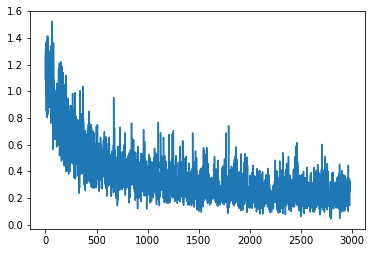

In [68]:
plt.plot(loss_list[20:])

In [ ]:
if is_best:
    save_checkpoint({'epoch': epoch,
                     'state_dict': model.state_dict(),
                     'optim_dict': optimizer.state_dict()}, 
                    is_best=is_best, loss=epoch_loss)

In [ ]:
load_saved_model()